1. Consider a medical test with a false positive rate $\alpha=P[x>\tau | H_0]$ , where $H_0$

    is the null hypothesis (the patient is healthy), x is the observed measurement,   

    and τ is the significance threshold. A test is run on a random patient and comes back positive (the null hypothesis is rejected). What is the probability.  

    that the patient truly has the condition?  

    양성이 나왔을때 실제 환자가 양성일 확률이므로 $\frac{TP}{FP+TP}$ 을 의미하므로 precision이 정답이다.    

    a. Is it $1-\alpha=P[x \le \tau | H_0]$ (the confidence of the test)?    

    b. Is it $1-\beta=P[x > \tau | H_1]$ (the power, or recall, of the test)?    

    c. Or is it $P[H_1| x> \tau]$ (the precision of the test)?   
        c이다. 

    d. Of the above, what do p-values measure?   
        환자가 건강할때 관측치가 $\tau$를 넘을 확률 즉, $\alpha$를 의미한다.  

    e. In finance, the analogous situation is to test whether a variable is involved in a phenomenon. Do p-values tell us anything about the probability that the variable is relevant, given the observed evidence?    
        변수가 현상에 관여할 확률이 아니라, 해당 변수가 무관하다고 가정했을때, 현재 관측치가 나올 확률을 의미하므로 p-value는 변수의 인과성, 관련성을 직접적으로   알려주지는 않고 단지 귀무가설($H_0$) 하에서 데이터가 얼마나 극단적인지를 말해주는 척도이다.  

2. Consider a medical test where $\alpha=0.01, \beta=0, $ and the probability of the condition is $P[H_1]=0.001$.   

    The test has full recall and a very high confidence. What is the probability that a positive-tested patient is actually sick?   

    recall=0 -> FN=0, $P[H_1]=0.001=TP+FN$, TP=0.001.  $\therefore precision=\frac{0.001}{0.01*0.999+0.001}=\frac{1}{11}$

    Why is it much lower than 1-α and 1-β? What is the probability that a patient is actually sick after testing positive twice on independent tests?

    유병율 $P[H_1]$ 이 낮기 때문에 condidence of the test나 recall 보다 작다,

    $P(++|H_1)=(1-\beta)^2=1, P(++|H_0)=\alpha^2=0.0001 \\
    P(H_1 | ++)=\frac{P(++|H_1)\pi}{P(++|H_1)\pi+P(++|H_0)(1-\pi)}=\frac{0.001}{0.001+0.0001*0.999} \approx 90.9\%
    $

3. Rerun the examples in Sections 6.3.1 and 6.3.2, where this time you pass an argument sigmaStd=0 to the getTestData function. 

    How do Figures 6.2 and 6.3 look now? What causes the difference, if there is one?

    figure에서 좀 더 feature들의 표준편차가 많아진것으로 보인다, 그 이유는 노이즈가 사라지면서 중복된 feature가 signal을 나누어가지는 subsitution effects가 더 강해졌기 때문이다.

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from typing import Literal

from sklearn.model_selection._split import KFold
from sklearn.metrics import log_loss

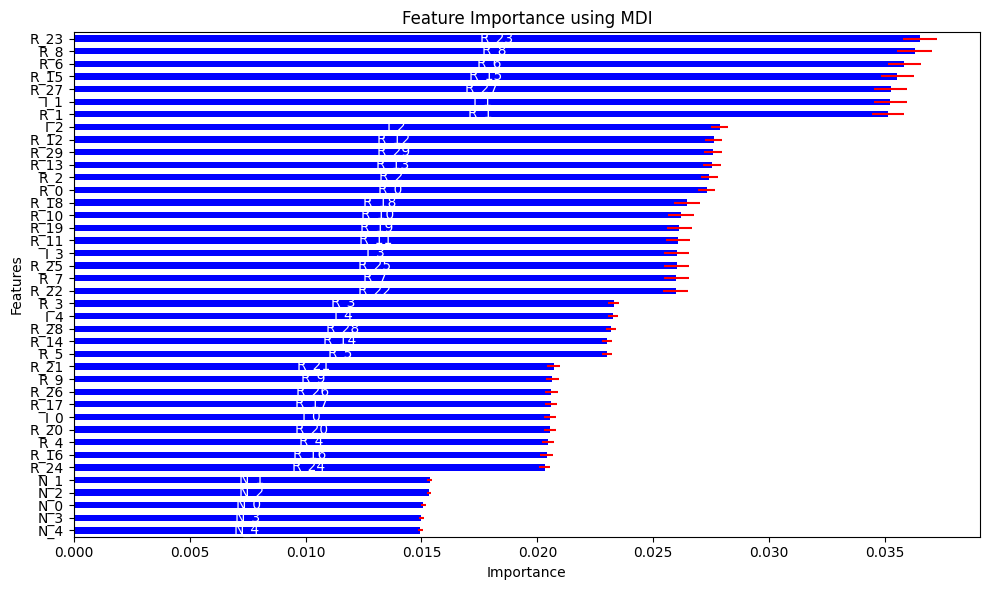

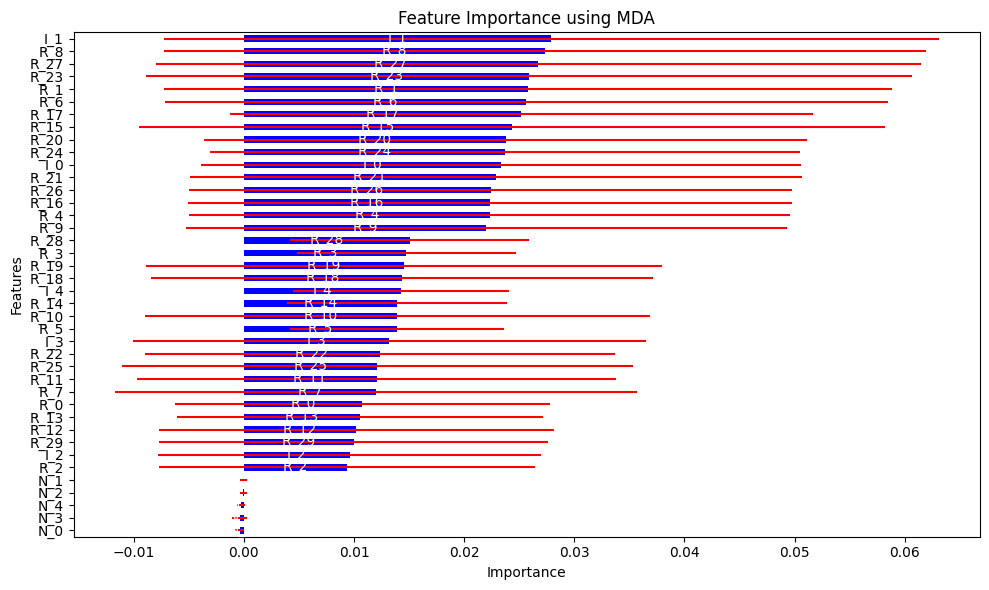

In [7]:
def get_test_data(n_features:int, n_info:int, n_redun:int, n_samples:int, redun_sigma:float, random_state=None,):
    np.random.seed(random_state)
    X, y=make_classification(n_samples=n_samples, n_features=n_features-n_redun, n_informative=n_info, n_redundant=0, shuffle=False, random_state=random_state)
    cols=[f'I_{i}' for i in range(n_info)]
    cols+=[f'N_{i}'for i in range(n_features-n_info-n_redun)]
    X, y=pd.DataFrame(X, columns=cols), pd.Series(y)
    redun_target_features=np.random.choice(range(n_info), n_redun)
    for i, target in enumerate(redun_target_features):
        X[f'R_{i}'] = X[f'I_{target}'] + np.random.normal(scale=redun_sigma, size=X.shape[0])
    return X, y


def get_mdi_importance(tree_cls_fit, feature_names:list):
    importance_dict={i:tree.feature_importances_ for i, tree in enumerate(tree_cls_fit.estimators_)}
    importance_df=pd.DataFrame.from_dict(importance_dict, orient='index', columns=feature_names)
    importance_df=importance_df.replace(0, np.nan)
    ret=pd.concat({'mean': importance_df.mean(), 'std': importance_df.std()/np.sqrt(importance_df.shape[0])}, axis=1)
    ret/=ret['mean'].sum() # normalization
    return ret

def plot_feature_importance(imp:pd.DataFrame, method_name:Literal['MDI', 'MDA']):
    plt.figure(figsize=(10, 6))
    imp=imp.sort_values('mean', ascending=True)
    ax=imp['mean'].plot(xerr=imp['std'], error_kw={'ecolor':'r'}, color='b', kind='barh')
    for i, j in zip(ax.patches, imp.index):
        ax.text(i.get_width()/2, i.get_y()+i.get_height()/2, j, ha='center', va='center', color='white', fontsize=10)
    plt.title(f'Feature Importance using {method_name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

def get_mda_importance(clf, X:pd.DataFrame, y:pd.Series, n_splits=5):
    cv_gen=KFold(n_splits=n_splits, shuffle=False)
    score_ori, score_shuffle=pd.Series(), pd.DataFrame(columns=X.columns)
    for i, (train_idx, test_idx) in enumerate(cv_gen.split(X)):
        X_train, y_train=X.iloc[train_idx, :], y.iloc[train_idx]
        X_test, y_test=X.iloc[test_idx, :], y.iloc[test_idx]
        fit=clf.fit(X_train, y_train)
        p_ori=fit.predict_proba(X_test)
        score_ori[i]=-log_loss(y_test, p_ori, labels=clf.classes_)
        for col in X.columns:
            X_test_shuffled=X_test.copy(deep=True)
            np.random.shuffle(X_test_shuffled[col].values)
            p_shuffled=fit.predict_proba(X_test_shuffled)
            score_shuffle.loc[i, col]=-log_loss(y_test, p_shuffled, labels=clf.classes_)
    imp=(-score_shuffle).add(score_ori, axis=0)
    imp/=(-score_shuffle) # (original-shuffled)/-shuffled (log loss에 음수 붙여준 것을 생각)
    imp=pd.concat({'mean': imp.mean(), 'std': imp.std()/np.sqrt(imp.shape[0])}, axis=1)
    return imp

X, y=get_test_data(40, 5, 30, 10000, 0.0)
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(estimator=clf, n_estimators=1000, n_jobs=-1, max_features=1.0, max_samples=1.0, oob_score=False)
fit=clf.fit(X, y)
importance_df=get_mdi_importance(fit, X.columns)
plot_feature_importance(importance_df, 'MDI')
importance_df_mda=get_mda_importance(clf, X, y)
plot_feature_importance(importance_df_mda, 'MDA')

4. Rerun the MDA analysis in Section 6.3.2, where this time you use probability weighted accuracy (Section 6.4)

    as the scoring function. Are results materially different?   

    Are they more intuitive or easier to explain? Can you think of other ways to represent MDA outputs using probability-weighted accuracy?  

    다른 점은 일단 음수가 나온 feature가 이전보다는 다양해졌다는 것이다. 
    log loss를 그대로 사용하는것보다는 확실히 잘 맞춘 정도를 반영하기 때문에 이해는 쉬운거 같다. 하지만 결과에서 Noise가 아닌 feature가 더 낮은 것은 의구심이 든다, 
    PWA도 cluster 단위로 하는것을 생각할 수 있을것 같다

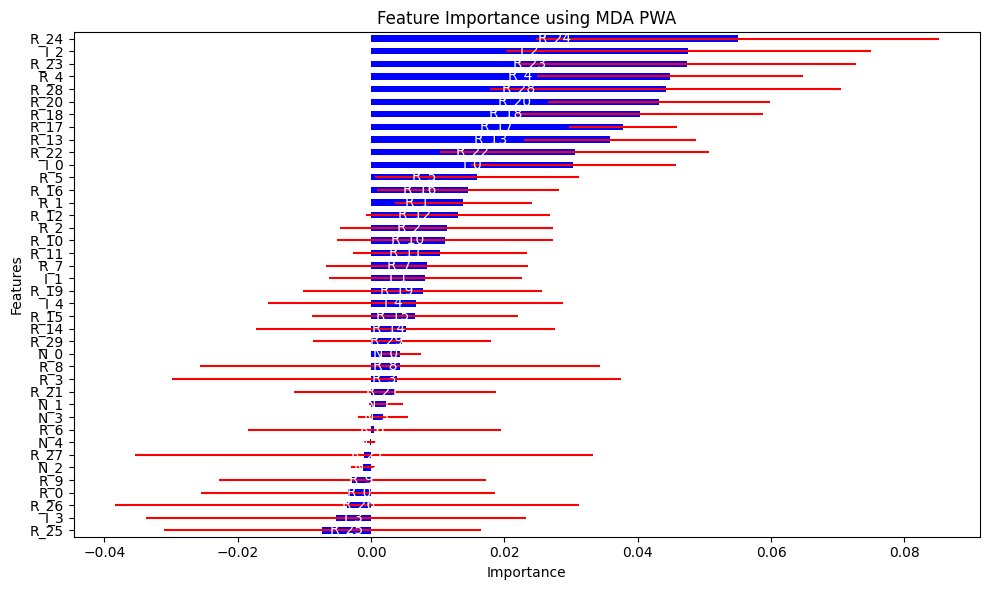

In [8]:
def get_mda_importance_pwa(clf, X:pd.DataFrame, y:pd.Series, n_splits=5):
    def get_pwa(y_true, y_pred_proba):
        max_prob=np.max(y_pred_proba, axis=1)
        label_cnt=y_pred_proba.shape[1]
        y_pred_true=np.where(y_true == np.argmax(y_pred_proba, axis=1), 1, 0)
        denom=np.sum(max_prob-1/label_cnt)
        if denom<=0:
            return np.nan
        pwa=np.sum(y_pred_true * (max_prob-1/label_cnt) / denom)
        return pwa
    cv_gen=KFold(n_splits=n_splits, shuffle=False)
    score_ori, score_shuffle=pd.Series(), pd.DataFrame(columns=X.columns)
    for i, (train_idx, test_idx) in enumerate(cv_gen.split(X)):
        X_train, y_train=X.iloc[train_idx, :], y.iloc[train_idx]
        X_test, y_test=X.iloc[test_idx, :], y.iloc[test_idx]
        fit=clf.fit(X_train, y_train)
        p_ori=fit.predict_proba(X_test)
        score_ori[i]=get_pwa(y_test, p_ori)
        for col in X.columns:
            X_test_shuffled=X_test.copy(deep=True)
            np.random.shuffle(X_test_shuffled[col].values)
            p_shuffled=fit.predict_proba(X_test_shuffled)
            score_shuffle.loc[i, col]=get_pwa(y_test, p_shuffled)
    imp=(-score_shuffle).add(score_ori, axis=0)
    eps=1e-12
    imp/=np.maximum(1.0-score_shuffle, eps)
    imp=pd.concat({'mean': imp.mean(), 'std': imp.std()/np.sqrt(imp.shape[0])}, axis=1)
    return imp

X, y=get_test_data(40, 5, 30, 10000, 0.1)
importance_df_mda_pwa=get_mda_importance_pwa(clf, X, y)
plot_feature_importance(importance_df_mda_pwa, 'MDA PWA')

5. Rerun the experiment in Section 6.6, where this time the distance metric used

    to cluster the features is variation of information (Section 3).

In [9]:
import scipy.stats as stats
from optimal_bins import get_optimal_bin_width, get_optimal_bin_width_2d
from sklearn.metrics import mutual_info_score

X, y=get_test_data(40, 5, 30, 10000, 0.1)
var_info=pd.DataFrame(0.0, index=X.columns, columns=X.columns)

for col1 in X.columns:
    for col2 in X.columns:
        if col1 != col2:
            bin1=get_optimal_bin_width(X.shape[0])
            corr = X[col1].corr(X[col2])
            bin2=get_optimal_bin_width_2d(X.shape[0], corr)
            cross_h_xy=np.histogram2d(X[col1], X[col2], bins=bin2)[0]
            mi = mutual_info_score(None, None, contingency=cross_h_xy)
            h_x=stats.entropy(np.histogram(X[col1], bins=bin1)[0])
            h_y=stats.entropy(np.histogram(X[col2], bins=bin1)[0])
            var_info.loc[col1, col2] = float(h_x + h_y - 2 * mi)
        else:
            continue

In [10]:
print(var_info.dtypes.unique())     # should be [float64]
print(np.isfinite(var_info.to_numpy()).all())  # should be True (or handle NaNs)

[dtype('float64')]
True


In [11]:
from optimized_kmean_clustering import KMeansClustering

kmeans=KMeansClustering('precomputed')
new_var_info, cluster_dict, sil=kmeans.cluster_kmeans_top(var_info)

<Axes: >

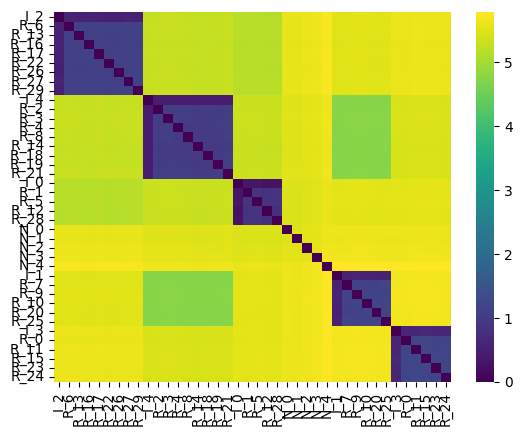

In [12]:

import seaborn as sns
sns.heatmap(new_var_info, cmap='viridis',xticklabels=True, yticklabels=True)